## Graph Classification with GNNs
- Given a dataset of graphs, we want to classify each (entire) graph, based on some structural graph properties.
- Here, we want to embed those graphs in such a way that they are linearly seperable (binary classification).

<img src="linearly_seperable_graphs.png" alt="Linearly Seperable" width="40%">

## The Data
We work in this notebook with the **MUTAG** dataset. 
- **Graphs are chemical compounds**:The MUTAG dataset represents chemical compounds, specifically mutagenic and non-mutagenic molecules. The graphs in the dataset describe the structure of these chemical compounds, with nodes representing atoms and edges representing chemical bonds.
- **Graph features**: Each graph in the MUTAG dataset consists of nodes, edges, and node and edge attributes. The node attributes typically represent atom types, and the edge attributes may represent bond types or other chemical properties.
- **Binary Classification**: The primary task associated with the MUTAG dataset is binary classification. Each graph is labeled as either "mutagenic" or "non-mutagenic," making it a binary classification problem.
- **Number of Graphs**: The dataset contains a relatively small number of graphs, typically around 188 graphs, split into training and testing subsets.




## References
- [TUDataset: A collection of benchmark datasets for learning with graphs](https://grlplus.github.io/papers/79.pdf)
- [Github datasets](https://chrsmrrs.github.io/datasets/)
- [PYG Colab Notebook](https://colab.research.google.com/drive/1I8a0DfQ3fI7Njc62__mVXUlcAleUclnb#scrollTo=e3tBQuI4n7hp)
- [Other PYG Official Examples](https://pytorch-geometric.readthedocs.io/en/latest/get_started/colabs.html)

In [1]:
import matplotlib.pyplot as plt
import networkx as nx
from sklearn.manifold import TSNE

import torch
import torch.nn.functional as F
from torch.nn import Linear

from torch_geometric.nn import GCNConv, global_mean_pool, GraphConv
from torch_geometric.datasets import TUDataset
from torch_geometric.loader import DataLoader
from torch_geometric.utils import to_networkx

In [2]:
def print_graph_stats(ix):
    data = dataset[ix]
    print(data)
    print(f'Number of nodes: {data.num_nodes}')
    print(f'Number of edges: {data.num_edges}')
    print(f'Average node degree: {data.num_edges / data.num_nodes:.2f}')
    print(f'Has isolated nodes: {data.has_isolated_nodes()}')
    print(f'Has self-loops: {data.has_self_loops()}')
    print(f'Is undirected: {data.is_undirected()}')

def visualize_graph(G):
    plt.figure(figsize=(5,5))
    plt.xticks([])
    plt.yticks([])
    nx.draw_networkx(G, pos=nx.spring_layout(G, seed=42), with_labels=False,
                     node_size=140)

def visualize_graph_embeddings(h, color=None):
    z = TSNE(n_components=2).fit_transform(h.detach().cpu().numpy())
    plt.figure()
    plt.scatter(z[:, 0], z[:, 1], s=50, c=color, cmap="Set2")
    plt.xticks([])
    plt.yticks([])

## Load the dataset

In [3]:
dataset = TUDataset(root="data/TUDataset", name="MUTAG")

In [4]:
print(f"Dataset: {dataset}")
print(f"Number of graphs: {len(dataset)}")
print(f"Number of features: {dataset.num_features}")
print(f"Number of classes: {dataset.num_classes}")

Dataset: MUTAG(188)
Number of graphs: 188
Number of features: 7
Number of classes: 2


## Inspect some graphs (each is a molecule)

Data(edge_index=[2, 38], x=[17, 7], edge_attr=[38, 4], y=[1])
Number of nodes: 17
Number of edges: 38
Average node degree: 2.24
Has isolated nodes: False
Has self-loops: False
Is undirected: True


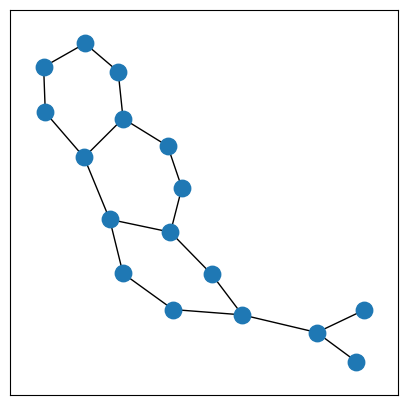

In [5]:
graph_index = 0
print_graph_stats(graph_index)
data = dataset[graph_index]
G = to_networkx(data, to_undirected=True)
visualize_graph(G)

Data(edge_index=[2, 38], x=[17, 7], edge_attr=[38, 4], y=[1])
Number of nodes: 17
Number of edges: 38
Average node degree: 2.24
Has isolated nodes: False
Has self-loops: False
Is undirected: True


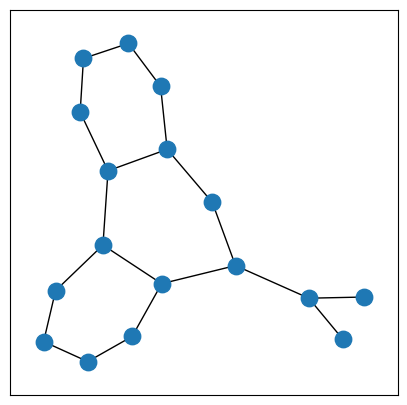

In [6]:
graph_index = 10
print_graph_stats(graph_index)
data = dataset[graph_index]
G = to_networkx(data, to_undirected=True)
visualize_graph(G)

Data(edge_index=[2, 26], x=[12, 7], edge_attr=[26, 4], y=[1])
Number of nodes: 12
Number of edges: 26
Average node degree: 2.17
Has isolated nodes: False
Has self-loops: False
Is undirected: True


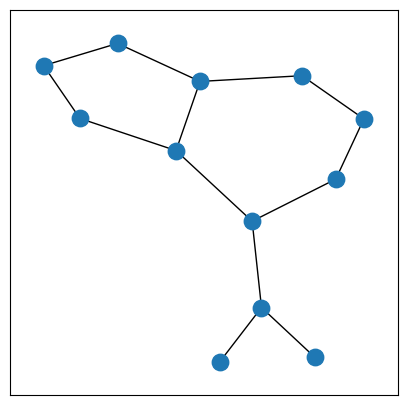

In [7]:
graph_index = 150
print_graph_stats(graph_index)
data = dataset[graph_index]
G = to_networkx(data, to_undirected=True)
visualize_graph(G)

## Split the graphs into training and test sets

In [8]:
torch.manual_seed(12345)
dataset = dataset.shuffle()
train_dataset = dataset[:150]
test_dataset = dataset[150:]
print(f'Number of training graphs: {len(train_dataset)}')
print(f'Number of test graphs: {len(test_dataset)}')

Number of training graphs: 150
Number of test graphs: 38


## Mini-batching of graphs

PyTorch Geometric automatically takes care of **batching multiple graphs into a single giant graph** with the help of the [`torch_geometric.data.DataLoader`](https://pytorch-geometric.readthedocs.io/en/latest/modules/data.html#torch_geometric.data.DataLoader) class. Read the section on [Mini-batching of graphs](https://colab.research.google.com/drive/1I8a0DfQ3fI7Njc62__mVXUlcAleUclnb#scrollTo=j11WiUr-PRH_) of how PyTorch Geometric gets around rescaling and padding. Essentially, the adjacency matrices are stacked in diagonal fashion, and the node and target features are concatenated in the node dimention.

Let's try `batch_size = 64`. This results in 3 batches of the training data (randomly shuffled), where each `Batch` equipped with a `batch` vector that maps each node to its respective graph in the batch. For example: 
$$\text{batch} = [0, ..., 0, 1, ..., 1, 2, 2, ...]$$


In [9]:
torch.manual_seed(12345)
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
for step, data in enumerate(train_loader):
    print(f"Step {step + 1}:")
    print(f"Number of graphs: {data.num_graphs}")
    print(data)
    print(" ")

Step 1:
Number of graphs: 64
DataBatch(edge_index=[2, 2586], x=[1170, 7], edge_attr=[2586, 4], y=[64], batch=[1170], ptr=[65])
 
Step 2:
Number of graphs: 64
DataBatch(edge_index=[2, 2460], x=[1114, 7], edge_attr=[2460, 4], y=[64], batch=[1114], ptr=[65])
 
Step 3:
Number of graphs: 22
DataBatch(edge_index=[2, 948], x=[430, 7], edge_attr=[948, 4], y=[22], batch=[430], ptr=[23])
 


In [10]:
data.batch

tensor([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
         1,  1,  1,  1,  1,  1,  1,  1,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,
         2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  3,  3,  3,  3,  3,
         3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,
         3,  3,  3,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  5,  5,  5,
         5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,
         5,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,
         6,  6,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,
         7,  7,  7,  7,  7,  7,  7,  7,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,
         8,  8,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,
         9,  9,  9,  9,  9,  9,  9, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10,
        10, 10, 10, 10, 10, 10, 10, 10, 

## Graph Neural Network for Graph Classification
Usually training GNN for graph classification follows these steps:
1. Embed each node by perfomring multiple rounds of message passing
2. Aggregate node embeddings into a unified graph embedding (**readout layer**)
3. Train a final classifier on the graph embedding

A common way to aggregate node embeddings is by taking the average of node embeddings:
$$
\mathbf{x}_{\mathcal{G}} = \frac{1}{|\mathcal{V}|} \sum_{v \in \mathcal{V}} \mathcal{x}^{(L)}_v
$$
PyTorch Geometric provides this functionality via [`torch_geometric.nn.global_mean_pool`](https://pytorch-geometric.readthedocs.io/en/latest/modules/nn.html#torch_geometric.nn.glob.global_mean_pool), which takes in the node embeddings of all nodes in the mini-batch and the assignment vector `batch` to compute a graph embedding of size `[batch_size, hidden_channels]` for each graph in the batch.


In [11]:
feature_size = dataset.num_node_features
hidden_size = 64
num_classes = dataset.num_classes

class GCN(torch.nn.Module):
    def __init__(self, hidden_size):
        super(GCN, self).__init__()
        torch.manual_seed(12345)
        self.conv1 = GCNConv(feature_size, hidden_size)
        self.conv2 = GCNConv(hidden_size, hidden_size)
        self.conv3 = GCNConv(hidden_size, hidden_size)
        self.lin = Linear(hidden_size, num_classes)
    def forward(self, x, edge_index, batch):
        # 1. Obtain node embeddings
        # x = F.dropout(x, p=0.5, training=self.training)
        h = self.conv1(x, edge_index)
        h = h.relu()
        h = self.conv2(h, edge_index)
        h = h.relu()
        h = self.conv3(h, edge_index)
        # 2. Readout layer (aggregate node embeddings into a graph embedding)
        h = global_mean_pool(h, batch)
        # 3. Apply a final classifier
        h = F.dropout(h, p=0.5, training=self.training)
        logits = self.lin(h)
        return logits, h

model = GCN(hidden_size)
print(model)

GCN(
  (conv1): GCNConv(7, 64)
  (conv2): GCNConv(64, 64)
  (conv3): GCNConv(64, 64)
  (lin): Linear(in_features=64, out_features=2, bias=True)
)


DataBatch(edge_index=[2, 2454], x=[1118, 7], edge_attr=[2454, 4], y=[64], batch=[1118], ptr=[65])
torch.Size([64, 64])
DataBatch(edge_index=[2, 2712], x=[1220, 7], edge_attr=[2712, 4], y=[64], batch=[1220], ptr=[65])
torch.Size([64, 64])
DataBatch(edge_index=[2, 828], x=[376, 7], edge_attr=[828, 4], y=[22], batch=[376], ptr=[23])
torch.Size([22, 64])


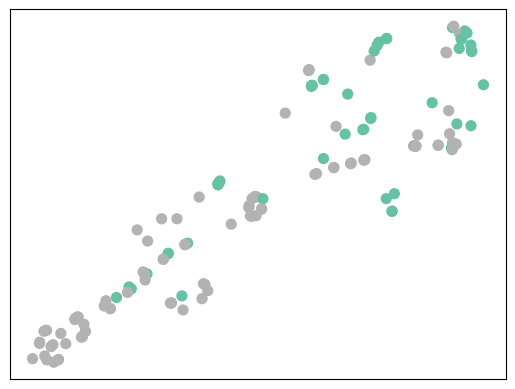

In [12]:
# Get graph embeddings from the UNTRAINED GCN model, color by true class assignment
model.eval()  # we don't want to run dropout
L = []
H = []
Y = []
for d in train_loader:
    print(d)
    logits, h = model(d.x, d.edge_index, d.batch)
    print(h.shape)
    L.append(logits)
    H.append(h)
    Y.append(d.y)
L = torch.concat(L)
H = torch.concat(H)
Y = torch.concat(Y)
visualize_graph_embeddings(H, Y)

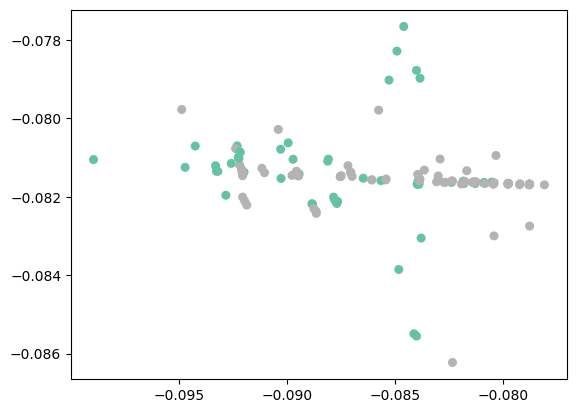

In [13]:
# Let's look directly at the logits, color by true class assignment
plt.scatter(L[:, 0].detach().cpu().numpy(), 
            L[:, 1].detach().cpu().numpy(), c=Y.detach().cpu().numpy(),
            cmap="Set2", s=30)

In [14]:
model = GCN(hidden_size)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = torch.nn.CrossEntropyLoss()

def train():
    model.train()
    correct = 0
    for batch_data in train_loader:
        optimizer.zero_grad()
        logits, _ = model(batch_data.x, batch_data.edge_index, batch_data.batch)
        loss = criterion(logits, batch_data.y)
        preds = logits.argmax(dim=1)
        batch_correct = preds == batch_data.y
        correct += int(batch_correct.sum())
        loss.backward()
        optimizer.step()
    accuracy = correct / len(train_loader.dataset)
    return accuracy

def test():
    model.eval()
    correct = 0
    for batch_data in test_loader:
        logits, _ = model(batch_data.x, batch_data.edge_index, batch_data.batch)
        preds = logits.argmax(dim=1)
        batch_correct = preds == batch_data.y
        correct += int(batch_correct.sum())
    accuracy = correct / len(test_loader.dataset)
    return accuracy

In [15]:
for epoch in range(1, 131):
    train_acc = train()
    test_acc = test()
    if epoch % 10 == 0:
        print(f'Epoch: {epoch:03d}, Train Acc: {train_acc:.4f}, Test Acc: {test_acc:.4f}')
# Epoch: 200, Train Acc: 0.7267, Test Acc: 0.7632

Epoch: 010, Train Acc: 0.6467, Test Acc: 0.7368
Epoch: 020, Train Acc: 0.7200, Test Acc: 0.8158
Epoch: 030, Train Acc: 0.7600, Test Acc: 0.7895
Epoch: 040, Train Acc: 0.7533, Test Acc: 0.7632
Epoch: 050, Train Acc: 0.7667, Test Acc: 0.7895
Epoch: 060, Train Acc: 0.7600, Test Acc: 0.7895
Epoch: 070, Train Acc: 0.7667, Test Acc: 0.7632
Epoch: 080, Train Acc: 0.7733, Test Acc: 0.7632
Epoch: 090, Train Acc: 0.7800, Test Acc: 0.7895
Epoch: 100, Train Acc: 0.7667, Test Acc: 0.7368
Epoch: 110, Train Acc: 0.7733, Test Acc: 0.7632
Epoch: 120, Train Acc: 0.7867, Test Acc: 0.7368
Epoch: 130, Train Acc: 0.8000, Test Acc: 0.7632


DataBatch(edge_index=[2, 2446], x=[1114, 7], edge_attr=[2446, 4], y=[64], batch=[1114], ptr=[65])
torch.Size([64, 64])
DataBatch(edge_index=[2, 2642], x=[1192, 7], edge_attr=[2642, 4], y=[64], batch=[1192], ptr=[65])
torch.Size([64, 64])
DataBatch(edge_index=[2, 906], x=[408, 7], edge_attr=[906, 4], y=[22], batch=[408], ptr=[23])
torch.Size([22, 64])


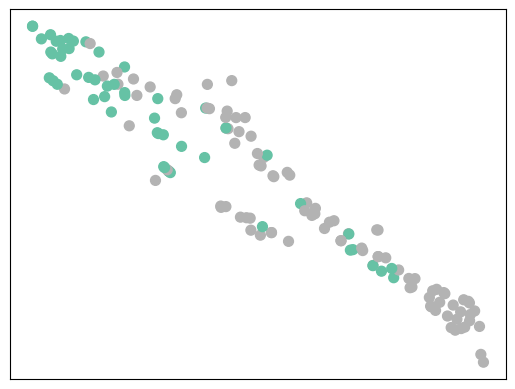

In [16]:
# Get graph embeddings from the TRAINED GCN model, color by true class assignment
model.eval()  # we don't want to run dropout
L = []
H = []
Y = []
for d in train_loader:
    print(d)
    logits, h = model(d.x, d.edge_index, d.batch)
    print(h.shape)
    L.append(logits)
    H.append(h)
    Y.append(d.y)
L = torch.concat(L)
H = torch.concat(H)
Y = torch.concat(Y)
visualize_graph_embeddings(H, Y)

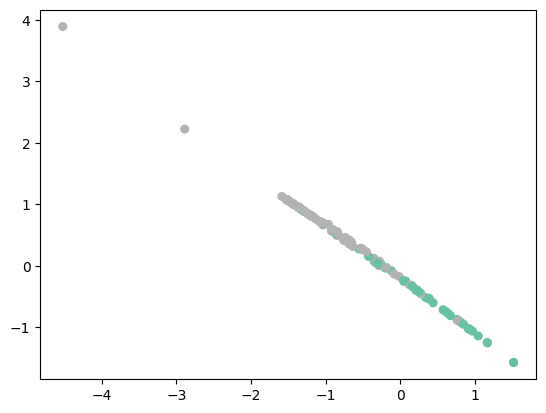

In [17]:
# Let's look directly at the logits, color by true class assignment
plt.scatter(L[:, 0].detach().cpu().numpy(), 
            L[:, 1].detach().cpu().numpy(), c=Y.detach().cpu().numpy(),
            cmap="Set2", s=30)

GCNConv applies neighborhood normalization. 

$$
\mathbf{x}_v^{(\ell + 1)} = \mathbf{W}^{(\ell + 1)} \sum_{u \in \mathcal{N}(v) \, \cup \, \{ v \}} \frac{1}{c_{u,v}} \cdot \mathbf{x}_u^{(\ell)}
$$.
where $c_{u,v}$ is the normalization coefficient for each edge

It is known that neighborhood normalization decreases the expressivity of GNNs in distinguishing certain graph structures. An alternative formulation was proposed by ([Morris et al. (2018)](https://arxiv.org/abs/1810.02244)), which omits neighborhood normalization completely.

$$
\mathbf{x}_v^{(\ell+1)} = \mathbf{W}^{(\ell + 1)}_1 \mathbf{x}_v^{(\ell)} + \mathbf{W}^{(\ell + 1)}_2 \sum_{u \in \mathcal{N}(v)} \mathbf{x}_u^{(\ell)}
$$

This layer is implemented under the name [`GraphConv`](https://pytorch-geometric.readthedocs.io/en/latest/modules/nn.html#torch_geometric.nn.conv.GraphConv) in PyTorch Geometric.

We observe significant improvement in both accuracy and clustering of embeddings. 

In [18]:
feature_size = dataset.num_node_features
hidden_size = 64
num_classes = dataset.num_classes

class AlternativeGCN(torch.nn.Module):
    def __init__(self, hidden_size):
        super(AlternativeGCN, self).__init__()
        torch.manual_seed(12345)
        self.conv1 = GraphConv(feature_size, hidden_size)
        self.conv2 = GraphConv(hidden_size, hidden_size)
        self.conv3 = GraphConv(hidden_size, hidden_size)
        self.lin = Linear(hidden_size, num_classes)
    def forward(self, x, edge_index, batch):
        # 1. Obtain node embeddings
        # x = F.dropout(x, p=0.5, training=self.training)
        h = self.conv1(x, edge_index)
        h = h.relu()
        h = self.conv2(h, edge_index)
        h = h.relu()
        h = self.conv3(h, edge_index)
        # 2. Readout layer (aggregate node embeddings into a graph embedding)
        h = global_mean_pool(h, batch)
        # 3. Apply a final classifier
        h = F.dropout(h, p=0.5, training=self.training)
        logits = self.lin(h)
        return logits, h

model = AlternativeGCN(hidden_size)
print(model)

AlternativeGCN(
  (conv1): GraphConv(7, 64)
  (conv2): GraphConv(64, 64)
  (conv3): GraphConv(64, 64)
  (lin): Linear(in_features=64, out_features=2, bias=True)
)


In [19]:
model = AlternativeGCN(hidden_size)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = torch.nn.CrossEntropyLoss()

def train():
    model.train()
    correct = 0
    for batch_data in train_loader:
        optimizer.zero_grad()
        logits, _ = model(batch_data.x, batch_data.edge_index, batch_data.batch)
        loss = criterion(logits, batch_data.y)
        preds = logits.argmax(dim=1)
        batch_correct = preds == batch_data.y
        correct += int(batch_correct.sum())
        loss.backward()
        optimizer.step()
    accuracy = correct / len(train_loader.dataset)
    return accuracy

def test():
    model.eval()
    correct = 0
    for batch_data in test_loader:
        logits, _ = model(batch_data.x, batch_data.edge_index, batch_data.batch)
        preds = logits.argmax(dim=1)
        batch_correct = preds == batch_data.y
        correct += int(batch_correct.sum())
    accuracy = correct / len(test_loader.dataset)
    return accuracy


for epoch in range(1, 131):
    train_acc = train()
    test_acc = test()
    if epoch % 10 == 0:
        print(f'Epoch: {epoch:03d}, Train Acc: {train_acc:.4f}, Test Acc: {test_acc:.4f}')


Epoch: 010, Train Acc: 0.7667, Test Acc: 0.8158
Epoch: 020, Train Acc: 0.7800, Test Acc: 0.8421
Epoch: 030, Train Acc: 0.8267, Test Acc: 0.7632
Epoch: 040, Train Acc: 0.8600, Test Acc: 0.7632
Epoch: 050, Train Acc: 0.8867, Test Acc: 0.8158
Epoch: 060, Train Acc: 0.9067, Test Acc: 0.8158
Epoch: 070, Train Acc: 0.8933, Test Acc: 0.8158
Epoch: 080, Train Acc: 0.9200, Test Acc: 0.8158
Epoch: 090, Train Acc: 0.8867, Test Acc: 0.8158
Epoch: 100, Train Acc: 0.9333, Test Acc: 0.7895
Epoch: 110, Train Acc: 0.9333, Test Acc: 0.8158
Epoch: 120, Train Acc: 0.9333, Test Acc: 0.8158
Epoch: 130, Train Acc: 0.8800, Test Acc: 0.8158


DataBatch(edge_index=[2, 2544], x=[1154, 7], edge_attr=[2544, 4], y=[64], batch=[1154], ptr=[65])
torch.Size([64, 64])
DataBatch(edge_index=[2, 2500], x=[1130, 7], edge_attr=[2500, 4], y=[64], batch=[1130], ptr=[65])
torch.Size([64, 64])
DataBatch(edge_index=[2, 950], x=[430, 7], edge_attr=[950, 4], y=[22], batch=[430], ptr=[23])
torch.Size([22, 64])


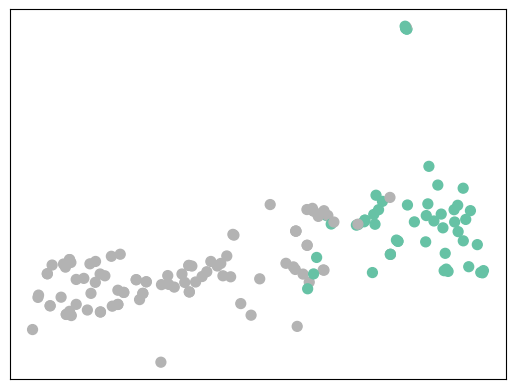

In [20]:
# Get graph embeddings from the TRAINED GCN model, color by true class assignment
model.eval()  # we don't want to run dropout
L = []
H = []
Y = []
for d in train_loader:
    print(d)
    logits, h = model(d.x, d.edge_index, d.batch)
    print(h.shape)
    L.append(logits)
    H.append(h)
    Y.append(d.y)
L = torch.concat(L)
H = torch.concat(H)
Y = torch.concat(Y)
visualize_graph_embeddings(H, Y)

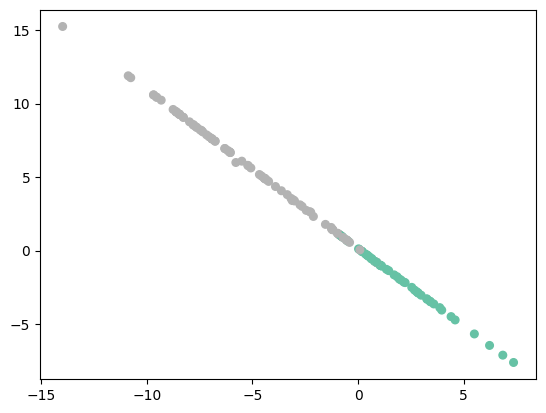

In [21]:
# Let's look directly at the logits, color by true class assignment
plt.scatter(L[:, 0].detach().cpu().numpy(), 
            L[:, 1].detach().cpu().numpy(), c=Y.detach().cpu().numpy(),
            cmap="Set2", s=30)

## `GCNConv` vs `GraphConv` 

1. `GCNConv` (Graph Convolutional Network Convolution):
   - `GCNConv` is based on the original Graph Convolutional Network (GCN) introduced by Thomas Kipf and Max Welling in their paper "Semi-Supervised Classification with Graph Convolutional Networks."
   - It performs graph convolutions using the neighborhood aggregation approach with normalization.
   - Specifically, it computes the convolution operation as a weighted sum of neighboring node features, where the weights are normalized by the degrees of the nodes.
   - `GCNConv` is suitable for graph classification and semi-supervised node classification tasks, where the graph structure is considered essential, and neighborhood normalization is desirable.

2. `GraphConv`:
   - `GraphConv` is a more general and flexible graph convolutional layer.
   - It doesn't enforce neighborhood normalization, making it suitable for a wider range of graph neural network (GNN) architectures.
   - You can use `GraphConv` when you want to implement custom graph convolutional layers or GNN architectures that do not rely on the specific neighborhood aggregation and normalization used in GCN.
   - It provides more control over the aggregation and message passing mechanisms in your GNN model.

In summary, the key difference is that `GCNConv` enforces neighborhood normalization based on the GCN formulation, while `GraphConv` is more flexible and can be used in a broader range of GNN architectures. Your choice between them depends on the specific requirements of your graph-based machine learning task and whether you need neighborhood normalization as part of the convolution operation.

## What about a skip-connection?
We add a skip-connection right after the `GraphConv` layers. This seems to boost performance.

In [22]:
class AlternativeGCN(torch.nn.Module):
    def __init__(self, hidden_size):
        super(AlternativeGCN, self).__init__()
        torch.manual_seed(12345)
        self.conv1 = GraphConv(feature_size, hidden_size)  
        self.conv2 = GraphConv(hidden_size, hidden_size)  
        self.conv3 = GraphConv(hidden_size, hidden_size)   
        self.lin_x = Linear(feature_size, hidden_size)  # Linear transformation for x
        self.lin = Linear(hidden_size, num_classes)
    def forward(self, x, edge_index, batch):
        # 1. Obtain node embeddings
        h = self.conv1(x, edge_index)
        h = h.relu()
        h = self.conv2(h, edge_index)
        h = h.relu()
        h = self.conv3(h, edge_index)
        
        # Apply a linear transformation to x to match dimensions with h
        x_transformed = self.lin_x(x)
        
        # Add a skip-connection by adding the transformed x to h
        h = h + x_transformed
        
        # 2. Readout layer (aggregate node embeddings into a graph embedding)
        h = global_mean_pool(h, batch)
        # 3. Apply a final classifier
        h = F.dropout(h, p=0.5, training=self.training)
        logits = self.lin(h)
        return logits, h

model = AlternativeGCN(hidden_size)
print(model)

AlternativeGCN(
  (conv1): GraphConv(7, 64)
  (conv2): GraphConv(64, 64)
  (conv3): GraphConv(64, 64)
  (lin_x): Linear(in_features=7, out_features=64, bias=True)
  (lin): Linear(in_features=64, out_features=2, bias=True)
)


In [23]:
model = AlternativeGCN(hidden_size)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = torch.nn.CrossEntropyLoss()

def train():
    model.train()
    correct = 0
    for batch_data in train_loader:
        optimizer.zero_grad()
        logits, _ = model(batch_data.x, batch_data.edge_index, batch_data.batch)
        loss = criterion(logits, batch_data.y)
        preds = logits.argmax(dim=1)
        batch_correct = preds == batch_data.y
        correct += int(batch_correct.sum())
        loss.backward()
        optimizer.step()
    accuracy = correct / len(train_loader.dataset)
    return accuracy

def test():
    model.eval()
    correct = 0
    for batch_data in test_loader:
        logits, _ = model(batch_data.x, batch_data.edge_index, batch_data.batch)
        preds = logits.argmax(dim=1)
        batch_correct = preds == batch_data.y
        correct += int(batch_correct.sum())
    accuracy = correct / len(test_loader.dataset)
    return accuracy


for epoch in range(1, 131):
    train_acc = train()
    test_acc = test()
    if epoch % 10 == 0:
        print(f'Epoch: {epoch:03d}, Train Acc: {train_acc:.4f}, Test Acc: {test_acc:.4f}')


Epoch: 010, Train Acc: 0.7467, Test Acc: 0.7895
Epoch: 020, Train Acc: 0.7933, Test Acc: 0.7895
Epoch: 030, Train Acc: 0.8267, Test Acc: 0.7632
Epoch: 040, Train Acc: 0.7933, Test Acc: 0.7895
Epoch: 050, Train Acc: 0.9000, Test Acc: 0.8421
Epoch: 060, Train Acc: 0.9267, Test Acc: 0.8421
Epoch: 070, Train Acc: 0.8800, Test Acc: 0.8421
Epoch: 080, Train Acc: 0.9133, Test Acc: 0.8421
Epoch: 090, Train Acc: 0.9133, Test Acc: 0.8421
Epoch: 100, Train Acc: 0.9000, Test Acc: 0.8421
Epoch: 110, Train Acc: 0.9333, Test Acc: 0.8158
Epoch: 120, Train Acc: 0.9400, Test Acc: 0.8684
Epoch: 130, Train Acc: 0.8933, Test Acc: 0.8421


DataBatch(edge_index=[2, 2582], x=[1160, 7], edge_attr=[2582, 4], y=[64], batch=[1160], ptr=[65])
torch.Size([64, 64])
DataBatch(edge_index=[2, 2598], x=[1181, 7], edge_attr=[2598, 4], y=[64], batch=[1181], ptr=[65])
torch.Size([64, 64])
DataBatch(edge_index=[2, 814], x=[373, 7], edge_attr=[814, 4], y=[22], batch=[373], ptr=[23])
torch.Size([22, 64])


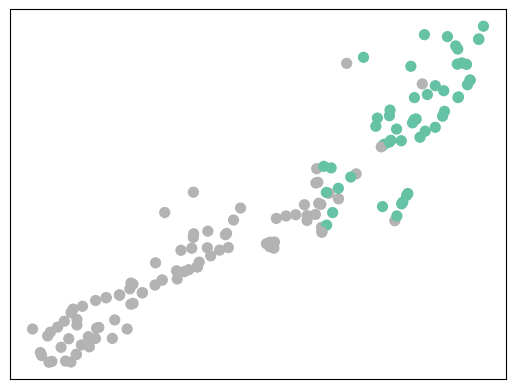

In [24]:
# Get graph embeddings from the TRAINED GCN model, color by true class assignment
model.eval()  # we don't want to run dropout
L = []
H = []
Y = []
for d in train_loader:
    print(d)
    logits, h = model(d.x, d.edge_index, d.batch)
    print(h.shape)
    L.append(logits)
    H.append(h)
    Y.append(d.y)
L = torch.concat(L)
H = torch.concat(H)
Y = torch.concat(Y)
visualize_graph_embeddings(H, Y)

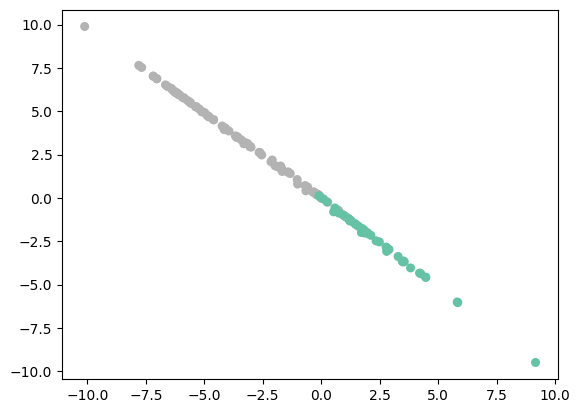

In [25]:
# Let's look directly at the logits, color by true class assignment
plt.scatter(L[:, 0].detach().cpu().numpy(), 
            L[:, 1].detach().cpu().numpy(), c=Y.detach().cpu().numpy(),
            cmap="Set2", s=30)